# Uber Demand


## Problem Overview


### Pasenger Hotspots

Uber is a US-based ride-hailing service like Gojek and Grab. To better assign drivers and adjust prices, Uber has to track hotspots (areas with high number of bookings) in its service area throughout the days. As shown in the picture, areas with dark red color are hotspots. When these hotspots occur, Uber will notify drivers so many of them can go around the area to find passengers.

A team of data scientists at Uber always monitor booking records and construct a heatmap. They will cluster bookings that happen around the same area based on their coordinate.

They then answer the following questions. How many clusters are there in every hourly interval? What is the demand in an area at a specified hour on a specified day?


## Dataset


### Trip Records

The dataset contains all uber trips happened in Chicago from January 1st, 2019. The following is the list of important columns.

  * Trip id
  * Trip start timestamp
  * Trip end timestamp
  * Pickup centroid latitude
  * Pickup centroid longitude

The dataset temporarily could be accessed on [http://35.225.11.165/Dataset/Taxi_Trips-2.csv](http://35.225.11.165/Dataset/Taxi_Trips-2.csv)


## Analysis


### Number of Hotspots

Can you find out how many clusters there are in every interval hour on a specific day? What is the highest demand of each time and day? It would be better if you can visualize the clusters in a scatter plot.


### Demand Prediction

Define small squares of geographical area based on longitude and latitude. Predict demand around each areas that will happened at a specific time and on a specific day. The simplest demand prediction is the average demand on a specific time and day. Visualise the heatmaps if possible.


## Presentation Structure


  * Start from problem overview.
  * Explain how you explore the data
  * Explain data preprocessing process that you do.
  * Predictive model that you build
  * Present them in great visualizations
  * Results and conclusion
  

# Solution

## Import library and datas

In [1]:
from datetime import datetime

import ipywidgets

import time

import gmaps

from matplotlib import pyplot

import pandas

from sklearn.cluster import KMeans

import constants

gmaps.configure(api_key=constants.API_KEY)

In [2]:
# raw_datas = pandas.read_csv("http://35.225.11.165/Dataset/Taxi_Trips-2.csv")
raw_datas = pandas.read_csv("../../Taxi_Trips-2.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [3]:
clean_datas = raw_datas.rename(
    columns={
        "Trip ID"                  : "id",
        "Trip Start Timestamp"     : "start_time",
        "Trip End Timestamp"       : "end_time",
        "Pickup Centroid Latitude" : "pickup_lat",
        "Pickup Centroid Longitude": "pickup_long",
    }
).drop(
    columns=[
        "Taxi ID",
        "Trip Seconds",
        "Trip Miles",
        "Pickup Census Tract",
        "Dropoff Census Tract",
        "Pickup Community Area",
        "Dropoff Community Area",
        "Fare",
        "Tips",
        "Tolls",
        "Extras",
        "Trip Total",
        "Payment Type",
        "Company",
        "Pickup Centroid Location",
        "Dropoff Centroid Latitude",
        "Dropoff Centroid Longitude",
        "Dropoff Centroid  Location",
    ]
)

clean_datas = clean_datas.drop_duplicates(
).dropna(
).reset_index(
    drop=True,
)

def get_interval(s):
    _temp = datetime.strptime(s, "%m/%d/%Y %I:%M:%S %p")
    return 24 * _temp.weekday() + _temp.hour

def get_unix(s):
    _temp = datetime.strptime(s, "%m/%d/%Y %I:%M:%S %p")
    return (_temp - datetime(1970,1,1)).total_seconds()

clean_datas["start_time_segment"] = clean_datas.start_time.apply(get_interval)
clean_datas["start_time_unix"] = clean_datas.start_time.apply(get_unix)
clean_datas["end_time_unix"] = clean_datas.end_time.apply(get_unix)

clean_datas = clean_datas[
    (0 <= clean_datas.end_time_unix-clean_datas.start_time_unix)
    & (clean_datas.end_time_unix-clean_datas.start_time_unix < 90*3600)
].drop(
    columns=[
        "start_time_unix",
        "end_time_unix",
    ]
)

## Data Grouping (based on time segment)

In [4]:
segmented_datas = [
    clean_datas[
        clean_datas.start_time_segment == i
    ].reset_index(
        drop=True,
    )
    for i in range(168)
]

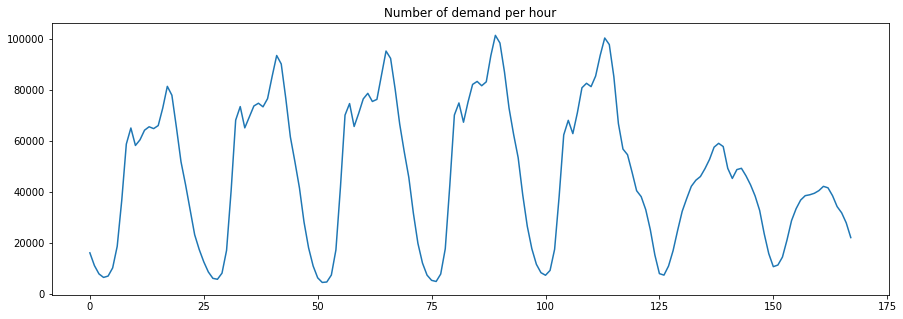

In [5]:
segmented_datas_length = pandas.DataFrame({
    "len": [len(data) for data in segmented_datas],
})

_ = pyplot.figure(figsize=(15,5))
_ = pyplot.title("Number of demand per hour")
_ = pyplot.plot(segmented_datas_length)

Based on this chart, we can analyze and predict the pickup time of the demand

## Data Grouping (based on coordinates)

In [6]:
reduced_datas = [
    segmented_datas[i].groupby([
        "pickup_lat",
        "pickup_long",
    ]).count(
    ).reset_index(
    )
    for i in range(168)
]

pickup_coords = [
    reduced_datas[i][["pickup_lat", "pickup_long"]]
    for i in range(168)
]
pickup_frequency = [
    reduced_datas[i]["id"]
    for i in range(168)
]

## Data Clustering using KMeans (based on coordinates)

In [7]:
clustering_centers = []

for i in range(168):
    _datas = [
        (data.pickup_lat, data.pickup_long)
        for data in segmented_datas[i].itertuples()
    ]
    
    clusterer = KMeans(n_clusters=constants.N_CLUSTERS).fit(_datas)
    clustering_centers.append(clusterer.cluster_centers_)

# Data Visualization

In [8]:
class HeatmapAnimation(object):
    def __init__(self, datasets, weights, centers, delay):
        self._datasets = datasets
        self._weights = weights
        self._centers = centers
        self._widgets = ipywidgets.Label(
            value="",
            disabled=True,
        )

        self._figure = gmaps.figure(
            center=(41.90, -87.75),
            zoom_level=10.8,
        )
        self._current_index = 0

        self._heatmap_layer = gmaps.heatmap_layer(
            datasets[self._current_index],
            weights=weights[self._current_index],
        )
        self._center_layer = gmaps.marker_layer(
            centers[self._current_index],
        )
        self._figure.add_layer(self._heatmap_layer)
        self._figure.add_layer(self._center_layer)
        self._delay = delay

    def render(self):
        display(self._figure)
        display(self._widgets)

    def start_animation(self):
        while True:
            self._current_index = (self._current_index + 1) % len(self._datasets)
            self._render_current_dataset()
            time.sleep(self._delay)

    def _render_current_dataset(self):
        self._heatmap_layer.locations = self._datasets[self._current_index]
        self._heatmap_layer.weights = self._weights[self._current_index]
        self._center_layer.locations = self._centers[self._current_index]
        self._widgets.value = "Day {} Interval {}".format(
            constants.WEEKDAYS[self._current_index//24],
            self._current_index%24,
        )

In [9]:
animation = HeatmapAnimation(
    pickup_coords,
    pickup_frequency,
    clustering_centers,
    0.8,
)
animation.render()
animation.start_animation()

Figure(layout=FigureLayout(height='420px'))

Label(value='')

KeyboardInterrupt: 